# Description

Personality trait estimation from Big 5 videos

## Prepare dataset

* Download the Chalearn: First Impressions V2 dataset. Here you can find more information about the dataset: http://chalearnlap.cvc.uab.es/dataset/24/description/
Big5.zip contains all of the mp4 clips, and the ground truth annotations. The samples are mostly 15 seconds long video clips, with one speaker talking to the camera. There are five personality traits: Extraversion, Agreeableness, Conscientiousness, Neuroticism and Openness. All target variables have continous values between [0, 1].
(regression task)

* Preprocess the data.
  * Audio representation: 
    * Extract the audio from the video. (Tips: use ffmpeg.)
    * Extract 24 Mel Frequency Cepstral Coefficients from the audio. (Tips: use librosa.)
    * Calculate the mean number of (spectral) frames in the dataset.
    * Standardize the MFCCs sample-wise. (Tips: zero mean and unit variance)
    * Use pre-padding (Note: with 0, which is also the mean after standardization) to unify the length of the samples.
    * Audio representation per sample is a tensor with shape (N,M,1) where N is the number of coefficients (e.g. 24) and M is the number of audio frames.
  * Visual representation:
    * Extract the frames from the video. (Tips: use ffmpeg.)
    * Resize the images to 140x248 to preserve the aspect ratio. (Tips: You can use lower/higher resolution as well.)
    * Subsample the frames to reduce complexity (6 frames/video is enough).
    * Use random crop 128x128 for training, and center crop for the validation and test sets.
    * Apply other standard data augmentation techniques, and scaling [0, 1].
    * Video representation per sample is a tensor with shape (F,H,W,3) where F is the number of frames (e.g. 6), H and W are the spatial dimensions (e.g. 128).
  * Ground truth labels:
    * There are 5 targets. Plot the distributions of the 5 personality traits.
    * You have to deal with an enhanced 'regression-to-the-mean problem'.

* Use the original dataset train-valid-test splits defined by the authors.
* Create a generator, which iterates over the audio and visual representations. (Note: the generator should produce a tuple ([x0, x1], y), where x0 is the audio, x1 is the video representation, y is the ground truth. (Don't forget: y is 5x1 vector for every sample.)
* Print the size of each set, plot 3 samples: frames, MFCCs and their corresponding personality trait annotations. (Tips: use librosa for plotting MFCCs)

Alternative considerations. They may require additional steps:
* You can use Mean MFCCs vectors to further reduce complexity. Input of the corresponding subnetwork should be modified to accept inputs with shape (N, 1).
* You can use log-melspectrograms as well. Note, that raw spectrograms are displaying power. Mel scale should be applied on the frequency axis, and log on the third dimension (decibels are expected). You can use librosa for that (librosa.feature.melspectrogram, librosa.power_to_db)

## Create Model

* Create the audio subnetwork
  * Choose one of these:
    * BLSTM (64 units, return sequences) + Dropout 0.5 + BLSTM (64 units) + Dense (128 units, ReLU)
    * Conv1D (32 filters, 3x3) + BatchNorm + ReLU, Conv1D (32 filters, 3x3) + BatchNorm + ReLU, Conv1D (64 filters, 3x3) + BatchNorm + ReLU, LSTM (64 units) + Dropout 0.5 + Dense (128 units, ReLU)
    * Conv2D (32 filters, 3x3) + BatchNorm + ReLU, MaxPool2D, Conv2D (32 filters, 3x3) + BatchNorm + ReLU, MaxPool2D, Flatten, Dense (128 units, ReLU)
  * You can try other configurations, better submodels. Have a reason for your choice!
* Create the visual subnetwork
  * Choose a visual backbone, which is applied frame-wise (Tips: use TimeDistributed Layer for this):
    * VGG-like architecture (Conv2D + MaxPooling blocks)
    * ResNet50 / Inception architecture (Residual blocks, Inception cells)
  * Apply Max pooling over the time dimension to reduce complexity (or use GRU or LSTM for better temporal modelling)
  * You can try other configurations, better submodels (like 3D convolution nets). Have a reason for your choice!
* Model fusion:
  * Concatenate the final hidden representations of the audio and visual subnetwork.
  * Apply fully connected layers on it (256 units, ReLU), then an another dense layer (5 units, linear). (Tips: you can try sigmoid to squeeze the output between [0,1]. However, you might struggle with the 'regression-to-the-mean' problem, the model prediction will be around 0.5 all the time, which is a local minimum.)
  * You can feed multiple inputs to the Model using a list: 
  model = tf.keras.models.Model(inputs=[input_audio, input_video], outputs=output)

* Performance metric:
  * Use the 1-Mean Absolute Error (1-MAE) as the evaluation metric.

## Extra task (Optional)
  * It is an unnormalized metric, and because of the target variables follow a Gaussian distribution, the modell will achieve around 0.88
  * Try to beat it, by modifing any part of the task, e.g. subnetworks, input data, configurations, preprocessing steps. (0.89-0.90 is great, between 0.90-0.92 is possible as well)

**If you can go over 0.90, +1 is added to the final grade.**


## Additional notes

* Do the preprocessing steps offline, create pkl (or npy, hdf5, etc..) files, so you don't have to repeat most of the steps again. Then you can upload it, and train using colab without much struggling.
* Use Adam optimizer and a learning rate scheduler.
* Check the training curve. If overfitting happens, add more regularization: weight decay (L2: 1e-3, 5e-4, etc...), Dropout, augmentation.

## Final steps, evaluation

* Plot the training / validation curve.
* Plot the '1-MAE' performance metric.
* Calculate the coefficient of determination (R^2) regression metric on the train, validation and test sets after training! (Note, that monitoring this metric during training is not advised with small batch size, because it is noisy and misleading.)

In [51]:
import os
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import ffmpeg
from ffmpeg import Error
import cv2
import scipy.stats as ss
import pickle
import pandas as pd
import seaborn as sns

"""
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding, Flatten, Lambda
from keras import layers, models
from keras import backend as K
"""
import warnings
warnings.filterwarnings("ignore")


In [54]:
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'
gt_dir = 'gt'

train_vids = os.listdir(train_dir) #6000 train videos
valid_vids = os.listdir(valid_dir) #2000 valid videos
test_vids = os.listdir(test_dir) #2000 test videos
print(len(train_vids), len(valid_vids), len(test_vids))

6000 2000 2000


In [55]:
def melspectrogram(audio, sr=44100, n_mels=128):
    return librosa.amplitude_to_db(librosa.feature.melspectrogram(audio, sr=sr, n_mels=n_mels))

def show_melspectrogram(mel, sr=44100):
    plt.figure(figsize=(14,4))
    librosa.display.specshow(mel, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Log mel spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()
    plt.show()
            
def extract_audio(filename):
    try:
        out, err = (
            ffmpeg
            .input(filename)
            .output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100')
            .run(capture_stdout=True)
        )
    except Error as err:
        print(err.stderr)
        raise

    return np.frombuffer(out, np.float32)

In [57]:
ind = np.random.choice(len(train_vids))
train_vids[ind]

'xrxAyO8pKUo.003.mp4'

train/7kO7jYYUVWg.004.mp4


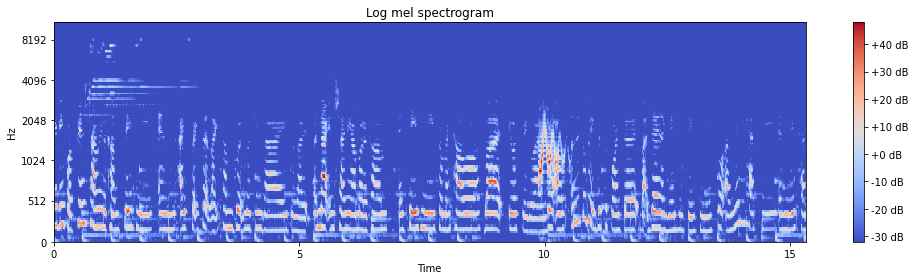

All smooth for : 0   train/7kO7jYYUVWg.004.mp4
train/mnRuiwFx_Z8.005.mp4


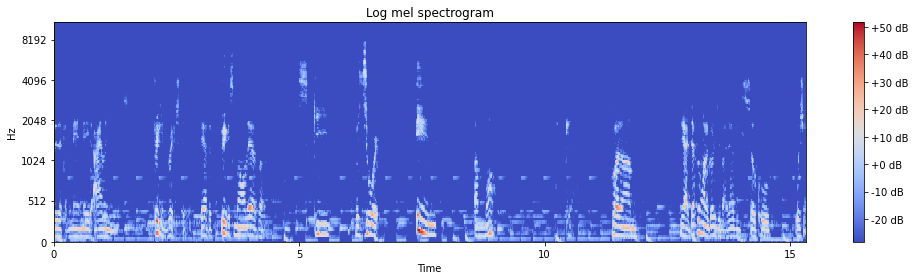

All smooth for : 1   train/mnRuiwFx_Z8.005.mp4


In [61]:
indices = np.random.choice(len(train_vids),2)
train_a_list = []
for i,ind in enumerate(indices):
    fpath = os.path.join(train_dir,train_vids[ind])
    print(fpath)
    if os.path.getsize(fpath) == 0:
        continue
    audio = extract_audio(fpath)
    """
    mfccs = librosa.feature.mfcc(y=audio,n_mfcc=24)
    std_mfccs = np.array(ss.zscore(mfccs)).reshape((24,-1,1))
    train_a_list.append(std_mfccs)
    train_audio = np.array(train_a_list)
    print(train_audio.shape)
    with open('pickle_files/train_audio.pkl', 'wb') as f:
        pickle.dump(train_audio, f, protocol=4)
    """
    show_melspectrogram(melspectrogram(audio))
    print("All smooth for :",str(i)," ",fpath)

In [ ]:
def load_audio(partition, partition_vids, partition_dir):
    a_list = []
    for i,file in enumerate(partition_vids):
        fpath = os.path.join(partition_dir,str(file))
        if os.path.getsize(fpath) == 0:
            continue
        audio = extract_audio(fpath)
        mfccs = librosa.feature.mfcc(y=audio,n_mfcc=24)
        #print('Before:',mfccs.shape)
        std_mfccs = np.pad(ss.zscore(mfccs),((0,0),(1319-mfccs.shape[1],0)),'constant').reshape((24,-1,1))
        #print('After:',mfccs.shape)
        a_list.append(std_mfccs)
    #outlier = [a.shape for a in a_list if a.shape != (24,1319,1)]
    #print(len(a_list),a_list[0].shape,len(outlier),outlier)
    audio_out = np.array(a_list)
    print(audio_out.shape)
    with open('pickle_files/{}_audio.pkl'.format(partition), 'wb') as f:
        pickle.dump(audio_out, f, protocol=4)


In [ ]:
load_audio('train', partition_vids = train_vids[:100], partition_dir = train_dir)    
load_audio('valid', partition_vids = valid_vids[:100], partition_dir = valid_dir)    
load_audio('test', partition_vids = test_vids[:100], partition_dir = test_dir)

In [5]:
def get_random_crop(image, crop_height=128, crop_width=128):

    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]/255. #random cropped and scaled to [0,1]

    return crop

def get_center_crop(image, crop_height=128, crop_width=128):

    crop = image[6: 6 + crop_height, 60: 60 + crop_width]/255. #center cropped and scaled to [0,1]

    return crop

In [ ]:
sample_ind = np.random.choice(len(train_vids),13)
sample_train = [train_vids[i] for i in sample_ind]
print(sample_train)
train_v_list = []
for i,file in enumerate(sample_train):
    file_frames = []
    fpath = os.path.join(train_dir,str(file))
    if os.path.getsize(fpath) == 0:
        continue
    video = cv2.VideoCapture(fpath)
    while True:
        ret, frame = video.read()
        if not ret:
            break
        #print(frame.shape, type(frame))
        frame_rescaled = cv2.resize(frame, dsize=(248, 140), interpolation=cv2.INTER_CUBIC)
        frame_cropped = get_random_crop(frame_rescaled) #random cropped and scaled to [0,1]
        #print(frame_rescaled.shape)
        file_frames.append(frame_rescaled)
    file_frames = np.array(file_frames)
    sample_frames = np.random.randint(file_frames.shape[0], size=6)
    file_frames_sampled = file_frames[sample_frames]
    train_v_list.append(file_frames_sampled)
train_video = np.array(train_v_list)
train_video.shape

In [9]:
def load_video_frames(partition, partition_vids, partition_dir):
    v_list = []
    for i,file in enumerate(partition_vids):
        file_frames = []
        fpath = os.path.join(partition_dir,str(file))
        if os.path.getsize(fpath) == 0:
            continue
        video = cv2.VideoCapture(fpath)
        while True:
            ret, frame = video.read()
            if not ret:
                break
            frame_rescaled = cv2.resize(frame, dsize=(248, 140), interpolation=cv2.INTER_CUBIC)
            if partition == 'train':
                frame_cropped = get_random_crop(frame_rescaled) #random cropped and scaled to [0,1]
            else:
                frame_cropped = get_center_crop(frame_rescaled) #center cropped and scaled to [0,1]
            file_frames.append(frame_cropped)
        file_frames = np.array(file_frames)
        sample_frames = np.random.randint(file_frames.shape[0], size=6)
        file_frames_sampled = file_frames[sample_frames]
        v_list.append(file_frames_sampled)
    video_out = np.array(v_list)
    print(video_out.shape)
    with open('pickle_files/{}_video.pkl'.format(partition), 'wb') as f:
        pickle.dump(video_out, f, protocol=4)

In [ ]:
load_video_frames('train', partition_vids = train_vids[:5], partition_dir = train_dir)    
load_video_frames('valid', partition_vids = valid_vids[:5], partition_dir = valid_dir)    
load_video_frames('test', partition_vids = test_vids[:5], partition_dir = test_dir)

In [ ]:
ind = np.random.choice(len(x_train))
# Set up matplotlib fig, and size it to fit 4x4 pics
nrows = 2
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(train_video[ind]):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  plt.imshow(train_video[ind][i])

plt.show()

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics

nrows = 2
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(valid_video[0]):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    plt.imshow(valid_video[0][i])

plt.show()

In [ ]:
sample_frames = np.random.randint(train_video.shape[0], size=6)
train_video_sampled = train_video[sample_frames]
train_video_sampled.shape

In [6]:
def load_gt(file):
    with open(os.path.join(gt_dir,file),'rb') as f:
        return pickle.load(f, encoding='latin1')

annot_train = load_gt('annotation_training.pkl')
annot_valid = load_gt('annotation_validation.pkl')
annot_test = load_gt('annotation_validation.pkl')

In [11]:
annot_train.keys()

dict_keys(['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'interview', 'openness'])

In [12]:
annot_test_len = {key:len(annot_test[key]) for key in annot_test.keys()}
annot_test_len                   

{'extraversion': 2000,
 'neuroticism': 2000,
 'agreeableness': 2000,
 'conscientiousness': 2000,
 'interview': 2000,
 'openness': 2000}

In [13]:
train_vid_files = set(os.listdir(train_dir))
valid_vid_files = set(os.listdir(valid_dir))
test_vid_files = set(os.listdir(test_dir))
train_vid_names = set(annot_train['extraversion'].keys())
valid_vid_names = set(annot_valid['extraversion'].keys())
test_vid_names = set(annot_test['extraversion'].keys())

assert(len(train_vid_files-train_vid_names)==0)
assert(len(valid_vid_files-valid_vid_names)==0)
assert(len(test_vid_files-test_vid_names)==0)

AssertionError: 

In [7]:
train_gt_df = pd.DataFrame(annot_train).drop(['interview'],axis=1)
valid_gt_df = pd.DataFrame(annot_valid).drop(['interview'],axis=1)
test_gt_df = pd.DataFrame(annot_test).drop(['interview'],axis=1)

In [8]:
train_gt_df.head()

,extraversion,neuroticism,agreeableness,conscientiousness,openness
J4GQm9j0JZ0.003.mp4,0.523364,0.552083,0.626374,0.601942,0.488889
zEyRyTnIw5I.005.mp4,0.345794,0.375000,0.472527,0.582524,0.366667
nskJh7v6v1U.004.mp4,0.252336,0.291667,0.406593,0.485437,0.511111
6wHQsN5g2RM.000.mp4,0.457944,0.489583,0.505495,0.398058,0.377778
dQOeQYWIgm8.000.mp4,0.607477,0.489583,0.406593,0.621359,0.622222


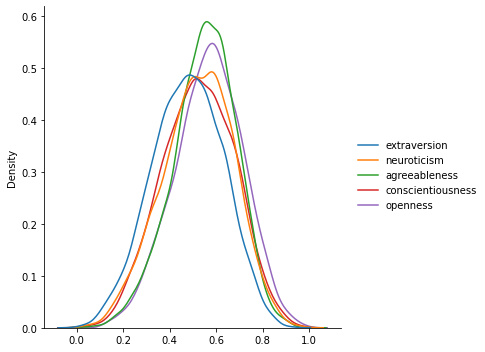

In [16]:
sns.displot(train_gt_df, kind='kde')

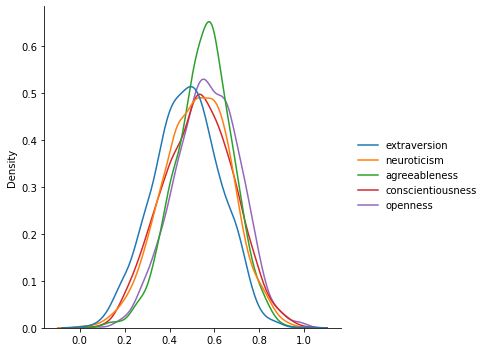

In [17]:
sns.displot(valid_gt_df, kind='kde')

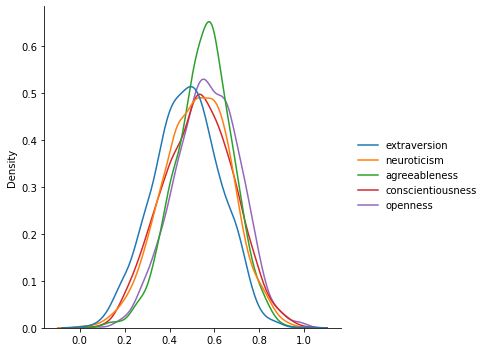

In [18]:
sns.displot(test_gt_df, kind='kde')

In [19]:
train_gt = np.array(train_gt_df)

In [20]:
np.expand_dims(np.array(train_gt_df.loc[train_vids[0]]),1).shape

(5, 1)

In [ ]:
def load_data(partition, partition_vids, partition_dir,gt):
    data = []
    for i,file in enumerate(partition_vids):
        file_frames = []
        fpath = os.path.join(partition_dir,str(file))
        if os.path.getsize(fpath) == 0:
            continue
        video = cv2.VideoCapture(fpath)
        while True:
            ret, frame = video.read()
            if not ret:
                break
            frame_rescaled = cv2.resize(frame, dsize=(248, 140), interpolation=cv2.INTER_CUBIC)
            if partition == 'train':
                frame_cropped = get_random_crop(frame_rescaled) #random cropped and scaled to [0,1]
            else:
                frame_cropped = get_center_crop(frame_rescaled) #center cropped and scaled to [0,1]
            file_frames.append(frame_cropped)
        file_frames = np.array(file_frames)
        sample_frames = np.random.randint(file_frames.shape[0], size=6)
        file_frames_sampled = file_frames[sample_frames]
        
        audio = extract_audio(fpath)
        mfccs = librosa.feature.mfcc(y=audio,n_mfcc=24)
        #print('Before:',mfccs.shape)
        std_mfccs = np.pad(ss.zscore(mfccs),((0,0),(1319-mfccs.shape[1],0)),'constant').reshape((24,-1,1))
        
        labels = np.expand_dims(np.array(gt.loc[file]),1)
        
        sample_tuple = ([std_mfccs, file_frames_sampled],labels)
        data.append(sample_tuple)
    data_out = np.empty(len(data), dtype=object)
    data_out[:] = data
    with open('pickle_files/{}_data.pkl'.format(partition), 'wb') as f:
        pickle.dump(data_out, f, protocol=4)
    

In [ ]:
load_data('train', partition_vids = train_vids, partition_dir = train_dir, gt=train_gt_df)    
load_data('valid', partition_vids = valid_vids, partition_dir = valid_dir, gt=valid_gt_df)    
load_data('test', partition_vids = test_vids, partition_dir = test_dir, gt=test_gt_df)


In [9]:
def check_data(file):
    with open(os.path.join('pickle_files',file),'rb') as f:
        return pickle.load(f, encoding='latin1')

train_data = check_data('train_data.pkl')
valid_data = check_data('valid_data.pkl')
test_data = check_data('test_data.pkl')

In [10]:
print(train_data.shape, type(train_data[0]))
print(type(train_data[0][0]), type(train_data[0][1]))
print(train_data[0][0][0].shape, train_data[0][0][1].shape, train_data[0][1].shape)

(6000,) <class 'tuple'>
<class 'list'> <class 'numpy.ndarray'>
(24, 1319, 1) (6, 128, 128, 3) (5, 1)


In [11]:
X_train, y_train = list(zip(*train_data))
y_train = np.array(y_train)
X_train_audio, X_train_video = list(zip(*X_train))
X_train_audio = np.array(X_train_audio)
X_train_video = np.array(X_train_video)

In [12]:
X_valid, y_valid = list(zip(*valid_data))
y_valid = np.array(y_valid)
X_valid_audio, X_valid_video = list(zip(*X_valid))
X_valid_audio = np.array(X_valid_audio)
X_valid_video = np.array(X_valid_video)

In [13]:
X_test, y_test = list(zip(*test_data))
y_test = np.array(y_test)
X_test_audio, X_test_video = list(zip(*X_test))
X_test_audio = np.array(X_test_audio)
X_test_video = np.array(X_test_video)

In [15]:
print(X_train_audio.shape, X_train_video.shape, y_train.shape)
print(X_valid_audio.shape, X_valid_video.shape, y_valid.shape)
print(X_test_audio.shape, X_test_video.shape, y_test.shape)

(6000, 24, 1319, 1) (6000, 6, 128, 128, 3) (6000, 5, 1)
(2000, 24, 1319, 1) (2000, 6, 128, 128, 3) (2000, 5, 1)
(2000, 24, 1319, 1) (2000, 6, 128, 128, 3) (2000, 5, 1)


Train output: [0.63551402 0.60416667 0.58241758 0.7961165  0.64444444]
Valid output: [0.61682243 0.66666667 0.67032967 0.7961165  0.73333333]
Test output: [0.70093458 0.72916667 0.72527473 0.76699029 0.72222222]


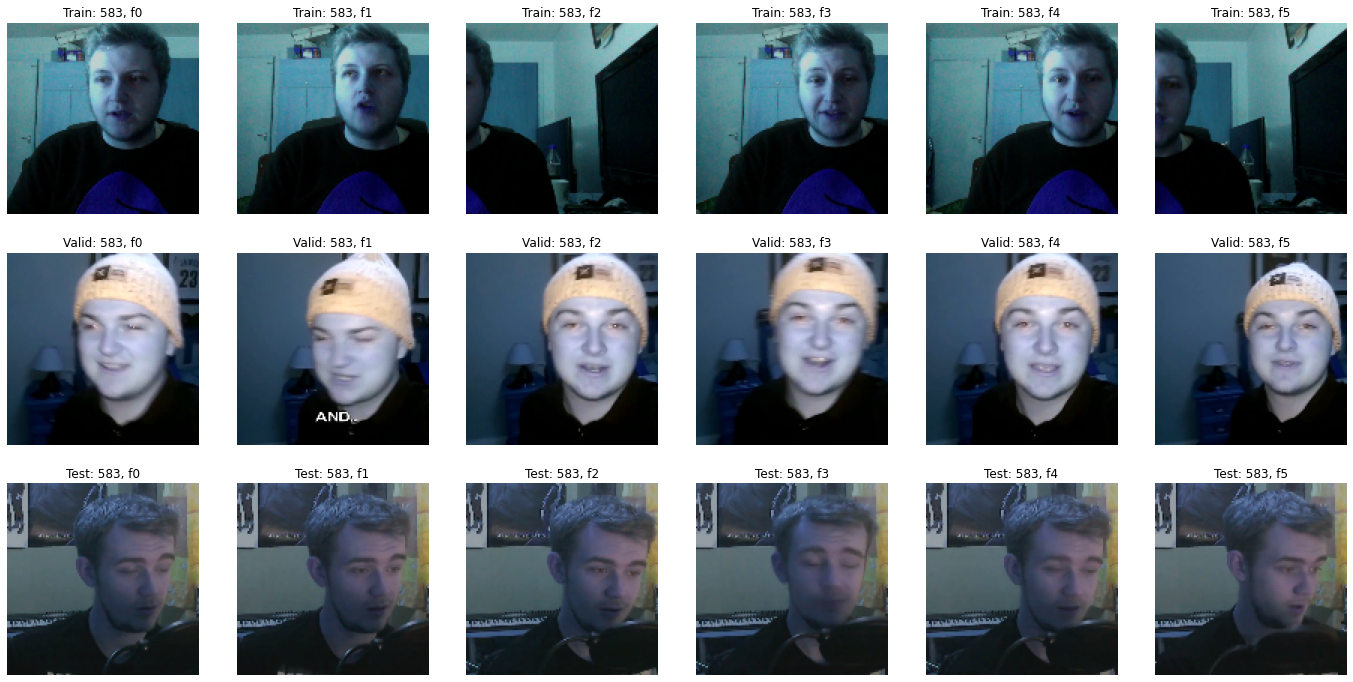

In [50]:
train_ind = np.random.choice(len(X_train_video))
valid_ind = np.random.choice(len(X_valid_video))
test_ind = np.random.choice(len(X_test_video))

index = np.r_[train_ind,valid_ind, test_ind]
# Set up matplotlib fig, and size it to fit 4x4 pics
nrows = 3
ncols = 6

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

i=0
for f in range(6):
    sp = plt.subplot(nrows, ncols, 6*i + f + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(X_train_video[index[i]][f])
    plt.title('Train: {}, f{}'.format(ind,f))

print('Train output: {}'.format(np.squeeze(y_train[ind])))
i=1
for f in range(6):
    sp = plt.subplot(nrows, ncols, 6*i + f + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(X_valid_video[index[i]][f])
    plt.title('Valid: {}, f{}'.format(ind,f))
print('Valid output: {}'.format(np.squeeze(y_valid[ind])))
i=2
for f in range(6):
    sp = plt.subplot(nrows, ncols, 6*i + f + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(X_test_video[index[i]][f])
    plt.title('Test: {}, f{}'.format(ind,f))
print('Test output: {}'.format(np.squeeze(y_test[ind])))
    


In [16]:
import sys
sys.executable
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding, Flatten, Lambda, Concatenate
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential

In [17]:
#audio subnetwork
a_shape = (24,1319)
audio_input = keras.Input(shape=a_shape)

a = Bidirectional(LSTM(64,return_sequences=True),input_shape=a_shape)(audio_input)
a = Dropout(.5)(a)
a = Bidirectional(LSTM(64))(a)
a = Dense(units=128, activation='relu')(a)
model_a = Model(inputs=audio_input, outputs=a)

#video subnetwork
video_input = layers.Input(shape=(6, 128, 128, 3), name='video_input')
cnn = vgg16.VGG16(weights="imagenet", include_top=False, pooling='avg')
cnn.trainable = False
v = layers.TimeDistributed(Lambda(lambda x: cnn(x)))(video_input)
v = layers.LSTM(64)(v)
model_v = Model(inputs=video_input, outputs=v)

combined = Concatenate()([model_a.output, model_v.output])
pt = Dense(256, activation='relu')(combined)
pt = Dense(5, activation='sigmoid')(pt)
model = Model(inputs=[model_a.input, model_v.input], outputs=pt)

adam_opt = keras.optimizers.Adam(lr=0.0005, decay=0.001)
model.compile(loss='mean_absolute_error',optimizer=adam_opt,metrics=['mae'])
model.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
  <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
  <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>
  <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv3/kernel:0' shape=(

In [18]:
history = model.fit([X_train_audio, X_train_video], y_train, batch_size=1, epochs=10, validation_data=([X_valid_audio, X_valid_video], y_valid), verbose=1)

Epoch 1/10
6000/6000 [==============================] - 353s 59ms/step - loss: 0.1102 - mae: 0.1102 - val_loss: 0.1058 - val_mae: 0.1058
Epoch 2/10
6000/6000 [==============================] - 125s 21ms/step - loss: 0.1027 - mae: 0.1027 - val_loss: 0.1046 - val_mae: 0.1046
Epoch 3/10
6000/6000 [==============================] - 125s 21ms/step - loss: 0.0990 - mae: 0.0990 - val_loss: 0.1058 - val_mae: 0.1058
Epoch 4/10
6000/6000 [==============================] - 125s 21ms/step - loss: 0.0962 - mae: 0.0962 - val_loss: 0.1065 - val_mae: 0.1065
Epoch 5/10
6000/6000 [==============================] - 125s 21ms/step - loss: 0.0942 - mae: 0.0942 - val_loss: 0.1066 - val_mae: 0.1066
Epoch 6/10
6000/6000 [==============================] - 126s 21ms/step - loss: 0.0920 - mae: 0.0920 - val_loss: 0.1065 - val_mae: 0.1065
Epoch 7/10
6000/6000 [==============================] - 125s 21ms/step - loss: 0.0903 - mae: 0.0903 - val_loss: 0.1076 - val_mae: 0.1076
Epoch 8/10
6000/6000 [===================

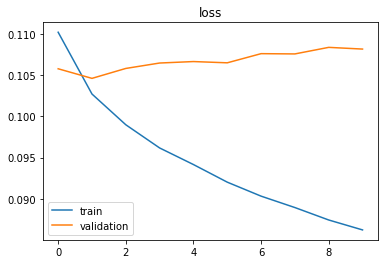

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('loss')
plt.legend()
plt.show()

In [21]:
model.evaluate([X_test_audio, X_test_video], y_test)

63/63 [==============================] - 11s 181ms/step - loss: 0.1043 - mae: 0.1043


[0.1043161004781723, 0.1043161004781723]

In [26]:
pred = model.predict([X_test_audio, X_test_video], batch_size=10)

In [35]:
index = np.random.choice(len(y_test),5)
for i,ind in enumerate(index):
    print("For sample {}".format(i))
    print("Prediction: "+str(pred[ind]))
    print("Gt: "+str(np.squeeze(y_test)[ind]))

For sample 0
Prediction: [0.3919561  0.48138383 0.5119172  0.45316964 0.4858    ]
Gt: [0.44859813 0.39583333 0.46153846 0.38834951 0.47777778]
For sample 1
Prediction: [0.44388255 0.5349138  0.62188023 0.5446625  0.5053898 ]
Gt: [0.51401869 0.53125    0.58241758 0.74757282 0.58888889]
For sample 2
Prediction: [0.34060252 0.32615155 0.36846754 0.3135555  0.42574143]
Gt: [0.30841121 0.34375    0.26373626 0.27184466 0.25555556]
For sample 3
Prediction: [0.3863919  0.4341664  0.44964424 0.35224584 0.513176  ]
Gt: [0.30841121 0.26041667 0.28571429 0.22330097 0.46666667]
For sample 4
Prediction: [0.4062713  0.44696945 0.5396843  0.4531647  0.47694898]
Gt: [0.18691589 0.34375    0.28571429 0.33009709 0.3       ]


In [62]:
col = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
pred_df = pd.DataFrame(pred, columns=col)

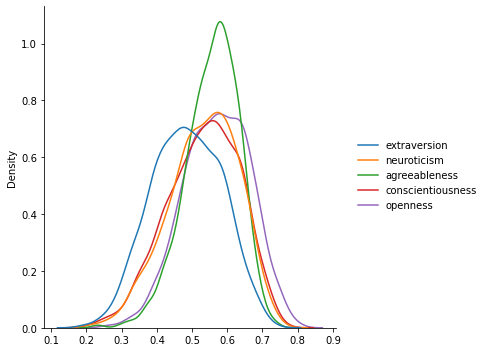

In [64]:
sns.displot(pred_df, kind='kde')

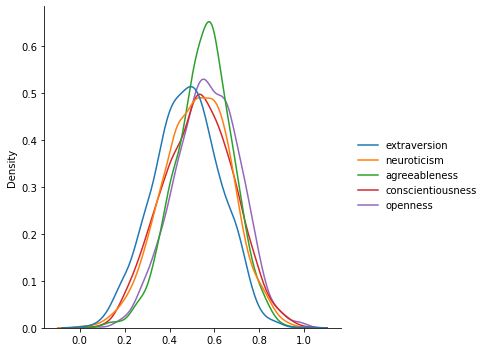

In [65]:
sns.displot(test_gt_df, kind='kde')

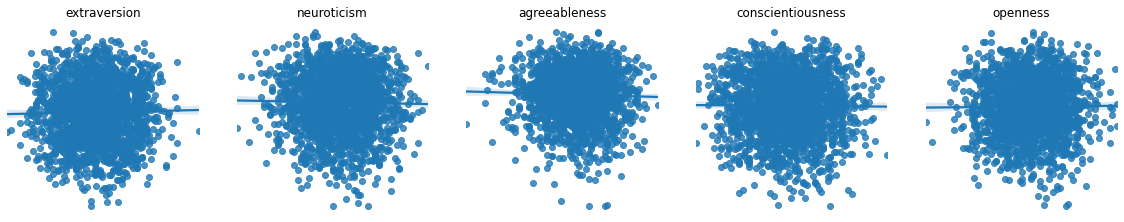

In [72]:
nrows = 3
ncols = 6

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

cols = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
for i,col in enumerate(cols):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    sns.regplot(test_gt_df[col],pred_df[col])
    plt.title(col)
    plt.xlabel('ground_truth')
    plt.ylabel('prediction')


In [77]:
?sns.jointplot